# Andrew Ng's Machine Learning Ex. 4 : Neural Network Learning

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
plt.rcParams['axes.formatter.limits'] = [-3,3]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Neural Networks

## 1.1 Visualizing the data

In [7]:
a = si.loadmat('../../data/digits_neural_networks.mat')
X = a['X']
yy = a['y'].flatten()

# replace 10 -> 0 because Matlab is stupid
#yy[np.flatnonzero(yy==10)] = 0

# re-cast y
y = np.zeros((len(yy), 10))
for ii in range(y.shape[0]):
    y[ii, yy[ii]-1] = 1

In [9]:
print(y, yy)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]] [10 10 10 ...  9  9  9]


In [10]:
def displayData(X, nrows=10, ncols=10):
    
    # set up array
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols,
                              figsize=(nrows,ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20,20, order='F')
            axarr[ii,jj].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)
    
    fig.subplots_adjust(hspace=0, wspace=0)

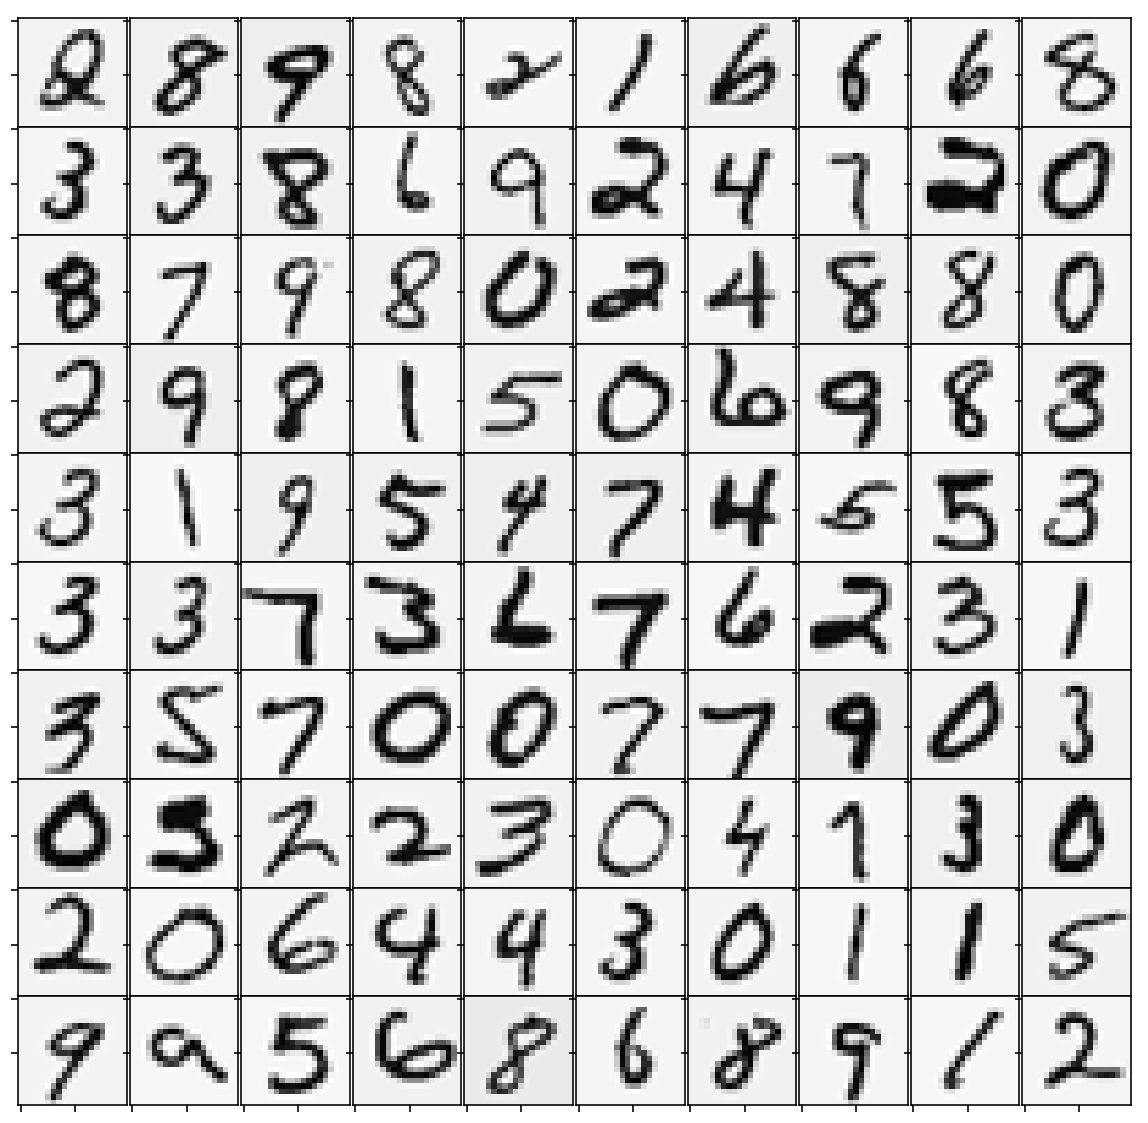

In [11]:
displayData(X)

## 1.2 Model representation

In [13]:
# read in pre-computed weights
a = si.loadmat('../../data/digits_neural_networks_weights.mat')
Theta1 = a['Theta1']
Theta2 = a['Theta2']

# unroll parameters
nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order='F'),
                            np.reshape(Theta2, Theta2.size, order='F')))

## 1.3 Feedforward and cost function

In [14]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    
    return sigmoid(z) * (1-sigmoid(z))

def randInitializeWeights(L_in, L_out):
    
    epsilon_int = 0.12
    W = np.random.rand(L_out, 1+L_in) * 2 * epsilon_int - epsilon_int
    
    return W

def compute_cost(Theta1, Theta2, X, y, lam):
    
    # tolerance for sigmoid function.
    # i.e., 1-htheta cannot be less than 1e-15
    # this fixes loss of precision errors
    eps = 1e-15
    
    # sizes
    m, n = X.shape
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
            
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    
    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    htheta = sigmoid(z3)
    
    # back prop
    delta3 = htheta - y
    delta2 = np.dot(delta3, Theta2)[:,1:] * sigmoidGradient(z2)
    #print np.dot(htheta, Theta2)[:,1:].shape, sigmoidGradient(z2).shape
        
    Delta1 = np.dot(delta2.T, X)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = 1 / m * Delta1
    Theta2_grad = 1 / m * Delta2
    
    # regularization
    Theta1_grad[:,1:] += lam / m * Theta1[:,1:]
    Theta2_grad[:,1:] += lam / m * Theta2[:,1:]
                
    # pack gradient
    grad = np.concatenate((np.reshape(Theta1_grad, Theta1_grad.size, order='F'),
                            np.reshape(Theta2_grad, Theta2_grad.size, order='F')))
    
            
    # compute J in three terms
    term1 = np.sum(np.log(htheta)* y)
    term2 = np.sum(np.log(1-htheta+eps)* (1-y))
    term3 =  lam / 2 * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2)) 
    
    # cost function
    J = - 1 / m * np.sum((term1 + term2 - term3)) 
    
    return J, grad
    
    
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam):
    
    # Reshape nn_params back into the parameters for Theta
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                        (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                        (num_labels, (hidden_layer_size+1)), order='F')
    
    # compute cost function
    J, grad = compute_cost(Theta1, Theta2, X, y, lam)
    
    return J, grad

In [15]:
# parameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [17]:
# compute cost function for trained parameters
J, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, 1)
print(J , grad.shape)

0.3837698590909145 (10285,)


In [19]:
# test sigmoid gradient
sg = sigmoidGradient(0)
print(sg)

0.25


## 2.4 Gradient Checking

In [23]:
def computeNumericalGradient(J, theta):
    
    numgrad = np.zeros(len(theta))
    perturb = np.zeros(len(theta))
    e = 1e-4
    for p in range(len(theta)):
        
        # Set perturbarion vactor
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

def checkNNGradients(lam=0):
    
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # generate some random test data
    Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    
    X = randInitializeWeights(input_layer_size-1, m)
    yy = 1 + np.mod(np.arange(m), num_labels)
    
    # re-cast y
    y = np.zeros((len(yy), num_labels))
    for ii in range(y.shape[0]):
        y[ii, yy[ii]-1] = 1
        
    
    # unroll parameters
    nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order='F'),
                            np.reshape(Theta2, Theta2.size, order='F')))
    
    # cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[0]
    
    cost, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    ct = 0
    for g, ng in zip(grad, numgrad):
        print(ct, g, ng, np.abs(g-ng) / ng)
        ct += 1
    
    

In [24]:
checkNNGradients()

0 0.002044576917930401 0.002044576916659935 6.213835051363582e-10
1 0.007492672311224433 0.007492672304820758 8.546584012402775e-10
2 -0.0005689607625496203 -0.0005689607629477678 -6.997801426073864e-10
3 0.006399271140441809 0.006399271135215656 8.166793894789204e-10
4 0.005120202571156688 0.005120202566377685 9.333620403568343e-10
5 0.00012222693443946075 0.00012222693523966655 6.546885864966332e-09
6 0.00017402412917557296 0.00017402413066136546 8.537853311900983e-09
7 9.180818191168289e-05 9.18081832779194e-05 1.488142409029573e-08
8 5.166413190979264e-05 5.166413075130549e-05 2.242343242926911e-08
9 0.00035761662083101057 0.00035761662076083667 1.9622662185738285e-10
10 -0.0005307519445996301 -0.000530751942395824 -4.152233583205812e-09
11 -9.958836170022342e-05 -9.958835978096658e-05 -1.927189929432363e-08
12 0.00020993720261928874 0.00020993720095674462 7.919244984832196e-09
13 -0.0003686629168226748 -0.00036866291575066157 -2.907841284277172e-09
14 -0.00012547060469091407 -0.00

## 2.5 Regularized Neural Networks

In [25]:
checkNNGradients(3)

0 0.004640261313793634 0.004640261310751015 6.556999496993454e-10
1 0.006288321421166168 0.0062883214169140444 6.76193779665325e-10
2 0.009315612298320364 0.009315612294891196 3.68109824562526e-10
3 -0.001652341956746555 -0.0016523419543723605 -1.436866241762612e-09
4 0.0023152969700031296 0.0023152969719220096 8.28783524849557e-10
5 -0.04170177128832254 -0.041701771289481826 -2.7799489268027433e-11
6 -0.0325732836380533 -0.03257328363481804 -9.932247908953616e-11
7 -0.021996519061721165 -0.021996519059541697 -9.908242324166171e-11
8 -0.02245264174606228 -0.022452641745829283 -1.0377293308731906e-11
9 -0.04949462451462055 -0.049494624514423435 -3.9825165068350216e-12
10 0.05070021807104674 0.05070021807052072 1.03751756715471e-11
11 -0.0689867294730471 -0.06898672947341922 -5.3940664403016145e-12
12 0.06948718916282112 0.06948718916266472 2.2508129984642357e-12
13 -0.01101519678058358 -0.011015196779151637 -1.2999705175186383e-10
14 0.017157790154836785 0.01715779015531993 2.8158916143

## 2.6 Learning parameters

In [26]:
def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p

In [27]:
lam = 1
maxiter = 400

# function prototypes
cost = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[0]

grad = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[1]

# initialize parameters
init_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

init_nn_params = np.concatenate((np.reshape(init_Theta1, init_Theta1.size, order='F'),
                            np.reshape(init_Theta2, init_Theta2.size, order='F')))

# run minimization
nn_params = fmin_cg(cost, init_nn_params, fprime=grad, maxiter=maxiter, disp=False)

# Reshape nn_params back into the parameters for Theta
Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                    (hidden_layer_size, input_layer_size+1), order='F')
Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                    (num_labels, (hidden_layer_size+1)), order='F')

In [29]:
p = predict(Theta1, Theta2, X)
print('Training set Accuracy: %2.2f percent' % (np.mean(p+1==yy)*100))

Training set Accuracy: 99.40 percent


# 3 Visualizing the hidden layer

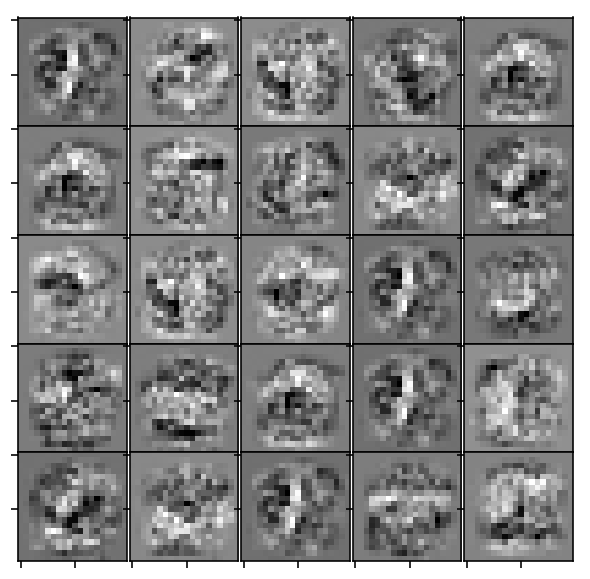

In [30]:
displayData(Theta1[:,1:], nrows=5, ncols=5)